In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sliderule import icesat2, earthdata
import pointCollection as pc
import datetime
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
gdf=gpd.read_file('/home/jovyan/shared-public/off_track/Sierra/HelheimGlacier-aoi.geojson')

print(f'gdf approx dimension:{np.sqrt(gdf.to_crs(3413).geometry[0].area)/1000} km')
poly=[]
for lon, lat in np.array(gdf.geometry[0].exterior.coords):
    poly += [{'lon':lon,'lat':lat}]
poly

gdf approx dimension:29.414503798801544 km


[{'lon': -38.66122193, 'lat': 66.52720495},
 {'lon': -38.65924571, 'lat': 66.31337474},
 {'lon': -37.67164882, 'lat': 66.26922273},
 {'lon': -37.6238204, 'lat': 66.36496834},
 {'lon': -38.18324224, 'lat': 66.43036511},
 {'lon': -38.20500866, 'lat': 66.52737905},
 {'lon': -38.66122193, 'lat': 66.52720495}]

In [4]:

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL06', polygon=poly)
print(len(granules_list))

185


In [5]:

parms_06 = {
        "poly":poly}
# run sliderule
D_06 = icesat2.atl06sp(parms_06, resources=granules_list).to_crs(3413)


In [6]:
print(f"originally found data with shape: {D_06.shape}")
D_06=D_06[D_06.atl06_quality_summary==0]
print(f"after subsetting, found data with shape: {D_06.shape}")


originally found data with shape: (493126, 21)
after subsetting, found data with shape: (414898, 21)


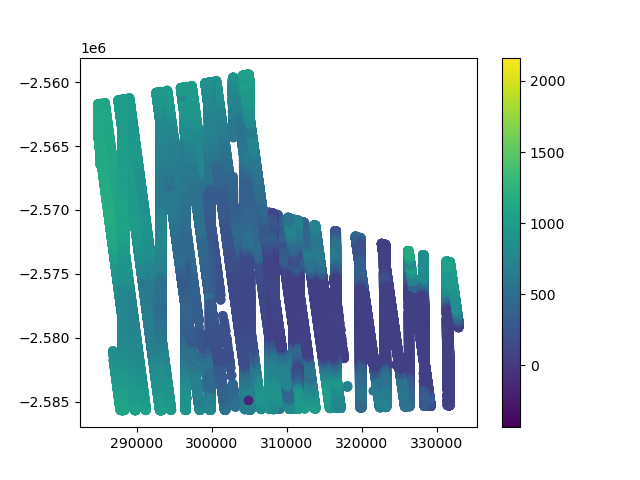

In [15]:
plt.figure()
plt.colorbar(plt.scatter(D_06.geometry.x, D_06.geometry.y, c=D_06.h_li))

In [18]:
# make a pointCollection.data object containing a subset of the data
# we will rename the h_li field to 'z' and the 'h_li_sigma' field to 'sigma'
D_full=pc.data().from_dict({field:np.array(D_06[field]) for field in ['spot','rgt','cycle','gt']})
D_full.assign({'x':np.array(D_06.geometry.x),
          'y':np.array(D_06.geometry.y), 
               'z':np.array(D_06.h_li),
               'sigma':np.array(D_06.h_li_sigma),
         't':np.array(D_06.index-datetime.datetime(2018, 1, 1)).astype(float)/1.e9/24/3600/365.25+2018})


<class 'pointCollection.data.data'> with shape (414898,),
with fields:
['spot', 'rgt', 'cycle', 'gt', 'x', 'y', 'z', 'sigma', 't']

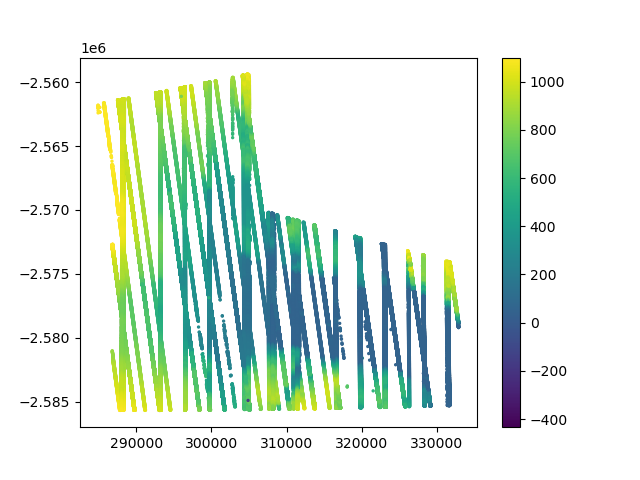

In [30]:
plt.figure()
plt.colorbar(plt.scatter(D_full.x[(D_full.z<1100)], D_full.y[(D_full.z<1100)], 2, c=D_full.z[(D_full.z<1100)]))

In [9]:
# reduce the data resolution to 80 m with a block median

_,rc_ind=pc.unique_by_rows(np.c_[D_full.cycle, D_full.rgt], return_dict=True)

D=[]
for rc, ind in rc_ind.items():
    D += [D_full[ind].blockmedian(80, 'z')]
D=pc.data().from_list(D)
print(D.summary())

field 	shape 	n_finite 	STD 	 minmax
spot	(119397,)	119397	1.72e+00	1.00e+00 6.00e+00
rgt	(119397,)	119397	3.94e+02	1.93e+02 1.37e+03
cycle	(119397,)	119397	6.42e+00	1.00e+00 2.30e+01
gt	(119397,)	119397	1.72e+01	1.00e+01 6.00e+01
x	(119397,)	119397	1.28e+04	2.85e+05 3.33e+05
y	(119397,)	119397	6.85e+03	-2.59e+06 -2.56e+06
z	(119397,)	119397	3.34e+02	-4.34e+02 2.16e+03
sigma	(119397,)	119397	1.96e-01	3.40e-03 1.00e+00
t	(119397,)	119397	1.59e+00	2.02e+03 2.02e+03


In [10]:
D.to_h5('../shared/staged_data/ATL06_helheim.h5')

In [2]:
np.max(D.t)

NameError: name 'D' is not defined

In [6]:
thicknessmap = pc.grid.data().from_geotif('/home/jovyan/shared-public/off_track/Sierra/ice_thickness_helheim_clipped2.tif')

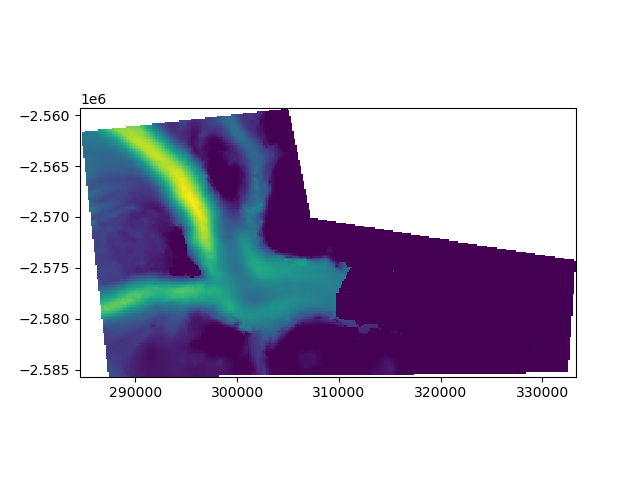

In [7]:
plt.figure()
thicknessmap.show()

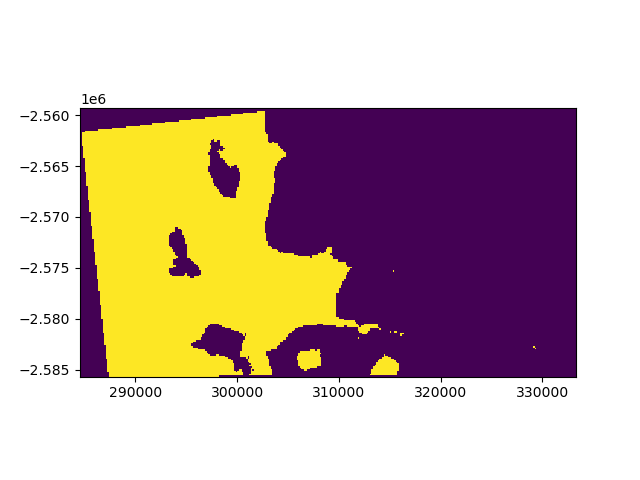

In [8]:
mask=pc.grid.data().from_dict({'x':thicknessmap.x,'y':thicknessmap.y,'z':thicknessmap.z>20})
plt.figure()
mask.show()